## _Response Modeling of Bank Marketing Campaign_

<br />

<img src="AI.png" width = '400'><br>


### _Business Scenario_

There has been a revenue decline for the Portuguese bank and they would like to know what actions to take. After investigation, we found out that the root cause is that their clients are not depositing as frequently as before. Knowing that term deposits allow banks to hold onto a deposit for a specific amount of time, so banks can invest in higher gain financial products to make a profit. In addition, banks also hold better chance to persuade term deposit clients into buying other products such as funds or insurance to further increase their revenues. As a result, the Portuguese bank would like to identify existing clients that have higher chance to subscribe for a term deposit and focus marketing effort on such clients.


* The task is to build a POC for the problem

* The data is related with direct marketing campaigns of a Portuguese banking institution. 

* The marketing campaigns were based on phone calls. 

* Often, more than one contact to the same client was required, in order to access if the product (bank term deposit) would be ('yes') or not ('no') subscribed. 

## _Attributes Information_


### _Bank client data:_
1 - age (numeric)

2 - job : type of job 
(categorical: 'admin.','blue-collar','entrepreneur','housemaid','management','retired','self-employed','services','student','technician','unemployed','unknown')

3 - marital : marital status 
(categorical: 'divorced','married','single','unknown'; note: 'divorced' means divorced or widowed)

4 - education (categorical:'basic.4y','basic.6y','basic.9y','high.school','illiterate','professional.course','university.degree','unknown')

5 - default: has credit in default? (categorical: 'no','yes','unknown')

6 - housing: has housing loan? (categorical: 'no','yes','unknown')

7 - loan: has personal loan? (categorical: 'no','yes','unknown')

### _Data Related to the last contact of the current campaign:_
8 - contact: contact communication type (categorical: 'cellular','telephone') 

9 - month: last contact month of year 
(categorical: 'jan', 'feb', 'mar', ..., 'nov', 'dec')

10 - day_of_week: last contact day of the week 
(categorical: 'mon','tue','wed','thu','fri')

11 - duration: last contact duration, in seconds (numeric). 
Important note: this attribute highly affects the output target (e.g., if duration=0 then y='no'). Yet, the duration is not known before a call is performed. Also, after the end of the call y is obviously known. Thus, this input should only be included for benchmark purposes and should be discarded if the intention is to have a realistic predictive model.

### _Other attributes:_

12 - campaign: number of contacts performed during this campaign and for this client 
(numeric, includes last contact)

13 - pdays: number of days that passed by after the client was last contacted from a previous campaign 
(numeric; 999 means client was not previously contacted)

14 - previous: number of contacts performed before this campaign and for this client (numeric)

15 - poutcome: outcome of the previous marketing campaign (categorical: 'failure','nonexistent','success')

### _Social and economic context attributes_
16 - emp.var.rate: employment variation rate - quarterly indicator (numeric)

17 - cons.price.idx: consumer price index - monthly indicator (numeric) 

18 - cons.conf.idx: consumer confidence index - monthly indicator (numeric) 

19 - euribor3m: euribor 3 month rate - daily indicator (numeric)

20 - nr.employed: number of employees - quarterly indicator (numeric)

Output variable (desired target):
21 - y - has the client subscribed a term deposit? (binary: 'yes','no')

In [1]:
# Set Directory
import os

## _Exploratory Analysis_

### _Import Libraries_

In [2]:
#! pip install imblearn

#if the above command does not work to install imblearn package run the following command in your terminal
# !conda install -c glemaitre

In [3]:
# !pip install seaborn

In [4]:
import pandas as pd
import numpy as np

from sklearn import preprocessing
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, recall_score, precision_score

import warnings
warnings.filterwarnings('ignore')

In [5]:
def convert_for_sklearn(label_list):
    return [1 if i == 'yes' else 0 for i in label_list]

def accuracy_precision_recall_metrics(y_true, y_pred):
    
    y_test_scoring = convert_for_sklearn(y_test)
    test_pred_scoring = convert_for_sklearn(y_pred)

    acc = accuracy_score(y_true= y_test_scoring, y_pred = test_pred_scoring)
    prec = precision_score(y_true= y_test_scoring, y_pred = test_pred_scoring)
    rec = recall_score(y_true= y_test_scoring, y_pred = test_pred_scoring)
    
    print("Test Precision: ",acc)
    print("Test Recall: ",prec)
    print("Test Accuracy: ",rec)

### _Read in the data_

from google.colab import drive
drive.mount('/content/drive')

!ls "/content/drive/My Drive/Colab Notebooks/CSE7305c_ML_Architecture"

In [6]:
bank_data = pd.read_csv("bank-additional-full.csv", sep=',', header=0,
                        na_values='unknown')
test_data =  pd.read_csv("test_cases.csv", sep=',', header=0, 
                         na_values='unknown')

print(bank_data.shape)
print(test_data.shape)

bank_data.head()

(41188, 22)
(4119, 22)


,customer_no,age,job,marital,education,credit_default,housing,loan,contact,contacted_month,...,campaign,pdays,previous,poutcome,emp_var_rate,cons_price_idx,cons_conf_idx,euribor3m,nr_employed,y
0,1,56,housemaid,married,basic.4y,no,no,no,telephone,may,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,2,57,services,married,high.school,NaN,no,no,telephone,may,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,3,37,services,married,high.school,no,yes,no,telephone,may,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,4,40,admin.,married,basic.6y,no,no,no,telephone,may,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,5,56,services,married,high.school,no,no,yes,telephone,may,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


### _Understand the dataset_

Undestanding the dataset can be as thorough as you want it to be, you can start by looking at the variables and asking questions, like the one's mentioned below.

In [7]:
# What are the names of the columns?
print(list(bank_data.columns))

['customer_no', 'age', 'job', 'marital', 'education', 'credit_default', 'housing', 'loan', 'contact', 'contacted_month', 'day_of_week', 'duration', 'campaign', 'pdays', 'previous', 'poutcome', 'emp_var_rate', 'cons_price_idx', 'cons_conf_idx', 'euribor3m', 'nr_employed', 'y']


In [8]:
# What are the data types?
bank_data.dtypes

customer_no          int64
age                  int64
job                 object
marital             object
education           object
credit_default      object
housing             object
loan                object
contact             object
contacted_month     object
day_of_week         object
duration             int64
campaign             int64
pdays                int64
previous             int64
poutcome            object
emp_var_rate       float64
cons_price_idx     float64
cons_conf_idx      float64
euribor3m          float64
nr_employed        float64
y                   object
dtype: object

In [9]:
# What is the distribution of numerical columns?
bank_data.describe()

,customer_no,age,duration,campaign,pdays,previous,emp_var_rate,cons_price_idx,cons_conf_idx,euribor3m,nr_employed
count,41188.00000,41188.00000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000
mean,20594.50000,40.02406,258.285010,2.567593,962.475454,0.172963,0.081886,93.575664,-40.502600,3.621291,5167.035911
std,11890.09578,10.42125,259.279249,2.770014,186.910907,0.494901,1.570960,0.578840,4.628198,1.734447,72.251528
min,1.00000,17.00000,0.000000,1.000000,0.000000,0.000000,-3.400000,92.201000,-50.800000,0.634000,4963.600000
25%,10297.75000,32.00000,102.000000,1.000000,999.000000,0.000000,-1.800000,93.075000,-42.700000,1.344000,5099.100000
50%,20594.50000,38.00000,180.000000,2.000000,999.000000,0.000000,1.100000,93.749000,-41.800000,4.857000,5191.000000
75%,30891.25000,47.00000,319.000000,3.000000,999.000000,0.000000,1.400000,93.994000,-36.400000,4.961000,5228.100000
max,41188.00000,98.00000,4918.000000,56.000000,999.000000,7.000000,1.400000,94.767000,-26.900000,5.045000,5228.100000


In [10]:
# What about categorical variable levels count?
bank_data.describe(include=['object'])

,job,marital,education,credit_default,housing,loan,contact,contacted_month,day_of_week,poutcome,y
count,40858,41108,39457,32591,40198,40198,41188,41188,41188,41188,41188
unique,11,3,7,2,2,2,2,10,5,3,2
top,admin.,married,university.degree,no,yes,no,cellular,may,thu,nonexistent,no
freq,10422,24928,12168,32588,21576,33950,26144,13769,8623,35563,36548


In [11]:
bank_data.marital.value_counts()

married     24928
single      11568
divorced     4612
Name: marital, dtype: int64

### _Distribition of dependent variable_

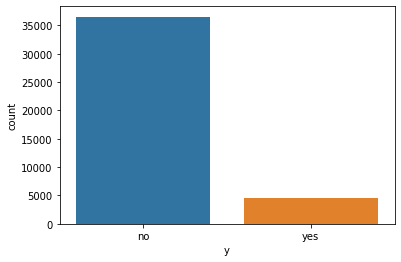

no     36548
yes     4640
Name: y, dtype: int64
Percentage of people who have taken the campaign: 11.265417111780131 %


In [12]:
# Plot Distribution
sns.countplot(x='y',data=bank_data)
plt.show()

# What are the counts?
print(bank_data.y.value_counts())

# What is the percentage?
count_yes = len(bank_data[bank_data.y == 'yes'])
count_no = len(bank_data[bank_data.y != 'yes'])

percent_success = (count_yes/(count_yes + count_no))*100

print('Percentage of people who have taken the campaign:', percent_success, "%")

### _Drawing trends toward the target variable_

In [13]:
bank_data.groupby('y').mean()

,customer_no,age,duration,campaign,pdays,previous,emp_var_rate,cons_price_idx,cons_conf_idx,euribor3m,nr_employed
y,,,,,,,,,,,
no,19354.359719,39.911185,220.844807,2.633085,984.113878,0.132374,0.248875,93.603757,-40.593097,3.811491,5176.166600
yes,30362.742888,40.913147,553.191164,2.051724,792.035560,0.492672,-1.233448,93.354386,-39.789784,2.123135,5095.115991


In [14]:
# Who are subscribing the most across job ranks?
bank_data[bank_data.y == 'yes'].job.value_counts(normalize=True)

admin.           0.293721
technician       0.158592
blue-collar      0.138605
retired          0.094286
management       0.071258
services         0.070172
student          0.059744
self-employed    0.032370
unemployed       0.031284
entrepreneur     0.026939
housemaid        0.023028
Name: job, dtype: float64

### _Feature Engineering_

#### _Fix levels of categorical variable by domain_

In [15]:
# Check levels of education. Is there anything wrong?
bank_data.education.value_counts()

# clean up basic level 
bank_data.replace(['basic.6y','basic.4y', 'basic.9y'], 'basic', inplace=True)

In [16]:
bank_data.education.value_counts()

basic                  12513
university.degree      12168
high.school             9515
professional.course     5243
illiterate                18
Name: education, dtype: int64

#### _Drop Unnecessary variables_

In [17]:
bank_data.drop("customer_no", axis = 1, inplace= True)
test_data.drop("customer_no", axis = 1, inplace= True)

bank_data.head()

,age,job,marital,education,credit_default,housing,loan,contact,contacted_month,day_of_week,...,campaign,pdays,previous,poutcome,emp_var_rate,cons_price_idx,cons_conf_idx,euribor3m,nr_employed,y
0,56,housemaid,married,basic,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,NaN,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


In [18]:
test_data.shape

(4119, 21)

#### _Type Casting_

In [19]:
for col in ['job', 'marital', 'education', 'credit_default', 'housing', 
            'loan', 'contact', 'contacted_month', 'day_of_week', 'poutcome', 
            'y']:
    bank_data[col] = bank_data[col].astype('category')

In [20]:
bank_data.dtypes

age                   int64
job                category
marital            category
education          category
credit_default     category
housing            category
loan               category
contact            category
contacted_month    category
day_of_week        category
duration              int64
campaign              int64
pdays                 int64
previous              int64
poutcome           category
emp_var_rate        float64
cons_price_idx      float64
cons_conf_idx       float64
euribor3m           float64
nr_employed         float64
y                  category
dtype: object

#### Split Numeric and Categorical Columns

In [21]:
cat_attr = list(bank_data.select_dtypes("category").columns)
num_attr = list(bank_data.columns.difference(cat_attr))

cat_attr.pop()

'y'

In [22]:
cat_attr

['job',
 'marital',
 'education',
 'credit_default',
 'housing',
 'loan',
 'contact',
 'contacted_month',
 'day_of_week',
 'poutcome']

In [23]:
num_attr

['age',
 'campaign',
 'cons_conf_idx',
 'cons_price_idx',
 'duration',
 'emp_var_rate',
 'euribor3m',
 'nr_employed',
 'pdays',
 'previous']

#### _Handle Missing Values_

In [24]:
bank_data.isnull().sum()

age                   0
job                 330
marital              80
education          1731
credit_default     8597
housing             990
loan                990
contact               0
contacted_month       0
day_of_week           0
duration              0
campaign              0
pdays                 0
previous              0
poutcome              0
emp_var_rate          0
cons_price_idx        0
cons_conf_idx         0
euribor3m             0
nr_employed           0
y                     0
dtype: int64

## Sklearn pipelines

Pipelines are a way to streamline a lot of the routine processes, encapsulating little pieces of logic into one function call, which makes it easier to actually do modeling instead just writing a bunch of code.

Pipelines are set up with the fit/transform/predict functionality, so you can fit a whole pipeline to the training data and transform to the test data, without having to do it individually for each thing you do. Super convenienent, right?

Steps to follow to create a pipeline

Step 1) Fetch the numerical and categorical columns

Step 2) Create a transformer/pipeline for numerical attributes

    Create a list of tuples where each tuple represents the operation to be performed on numerical attributes

Step 3) Create a transformer/pipeline for categorical attributes

    Create a list of tuples where each tuple represent the operation to be performed on categorical attributes

Step 4) Create a ColumnTransformer which merges both the numerical and categorical transformers

Step5) Create a final pipeline object which includes the ColumnTransformer and an estimator (an algorithm to be build on dataset)

Step6) (optional) Create a GridSearchCV object with pipeline as one of the inputs along with hyperparameter grid and Cross validation object

Step7) Apply fit() on train data and predict() on test data <br><br>

**TL; DR**
Pipeline is a collection of transformers chained together and operate sequentially. (often ending with an estimator)

__Bird's view of sklearn pipeline__

<img src="Pipeline_broadview.png"><br><br>

__Train and Test dataflow inside the sklearn pipeline__
<img src="fit_tranform.jpg">

#### _Instantiate Pre-processing Objects for Pipeline_

In [25]:
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent',fill_value="missing_value")),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, num_attr),
        ('cat', categorical_transformer, cat_attr)])

#### _Instantiate Pipeline Object_

In [26]:
clf_logreg = Pipeline(steps=[('preprocessor', preprocessor),
                      ('classifier', LogisticRegression())])

### _Train-Test Split_

In [27]:
X_train, y_train = bank_data.loc[:,bank_data.columns!='y'], bank_data.loc[:,'y']

X_test, y_test = test_data.loc[:,test_data.columns!='y'], test_data.loc[:,'y']

In [28]:
X_train.head(1)

,age,job,marital,education,credit_default,housing,loan,contact,contacted_month,day_of_week,duration,campaign,pdays,previous,poutcome,emp_var_rate,cons_price_idx,cons_conf_idx,euribor3m,nr_employed
0,56,housemaid,married,basic,no,no,no,telephone,may,mon,261,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0


### _Build Logistic Regression Model - 1_

In [29]:
clf_logreg.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('preprocessor',
                 ColumnTransformer(n_jobs=None, remainder='drop',
                                   sparse_threshold=0.3,
                                   transformer_weights=None,
                                   transformers=[('num',
                                                  Pipeline(memory=None,
                                                           steps=[('imputer',
                                                                   SimpleImputer(add_indicator=False,
                                                                                 copy=True,
                                                                                 fill_value=None,
                                                                                 missing_values=nan,
                                                                                 strategy='median',
                                                             

### _Evaluate Model_

In [30]:
train_pred = clf_logreg.predict(X_train)
test_pred = clf_logreg.predict(X_test)

### Build SVC Model 

In [31]:
accuracy_precision_recall_metrics(y_true = y_test, y_pred = test_pred)

Test Precision:  0.9092012624423403
Test Recall:  0.6476510067114094
Test Accuracy:  0.41774891774891776


In [32]:
### A. SVM (Linear  and RBF Models)

In [33]:
%%time
svc_lin = Pipeline(steps=[('preprocessor', preprocessor),
                      ('classifier', SVC())])
svc_lin.set_params(classifier__kernel='linear',classifier__C=1,
                   classifier__random_state=123)

svc_lin.fit(X_train,y_train)

Wall time: 1min 10s


Pipeline(memory=None,
         steps=[('preprocessor',
                 ColumnTransformer(n_jobs=None, remainder='drop',
                                   sparse_threshold=0.3,
                                   transformer_weights=None,
                                   transformers=[('num',
                                                  Pipeline(memory=None,
                                                           steps=[('imputer',
                                                                   SimpleImputer(add_indicator=False,
                                                                                 copy=True,
                                                                                 fill_value=None,
                                                                                 missing_values=nan,
                                                                                 strategy='median',
                                                             

In [34]:
train_pred =svc_lin.predict(X_train)
test_pred = svc_lin.predict(X_test)

In [35]:
accuracy_precision_recall_metrics(y_true = y_test, y_pred = test_pred)

Test Precision:  0.9053168244719592
Test Recall:  0.6636363636363637
Test Accuracy:  0.31601731601731603


In [36]:
### B. SVM (rbf kernel)

In [37]:
%%time
svc_rbf = Pipeline(steps=[('preprocessor', preprocessor),
                      ('classifier', SVC())])
svc_rbf.set_params(classifier__kernel='rbf',classifier__C=1,
                   classifier__gamma=0.01,classifier__random_state=123)

svc_rbf.fit(X_train,y_train)

Wall time: 45 s


Pipeline(memory=None,
         steps=[('preprocessor',
                 ColumnTransformer(n_jobs=None, remainder='drop',
                                   sparse_threshold=0.3,
                                   transformer_weights=None,
                                   transformers=[('num',
                                                  Pipeline(memory=None,
                                                           steps=[('imputer',
                                                                   SimpleImputer(add_indicator=False,
                                                                                 copy=True,
                                                                                 fill_value=None,
                                                                                 missing_values=nan,
                                                                                 strategy='median',
                                                             

In [38]:
train_pred =svc_rbf.predict(X_train)
test_pred = svc_rbf.predict(X_test)

In [39]:
#### Using the function to calculate accuracy, precision and recall.

accuracy_precision_recall_metrics(y_true = y_test, y_pred = test_pred)

Test Precision:  0.9058023792182569
Test Recall:  0.6745283018867925
Test Accuracy:  0.30952380952380953


### SVM (Grid Search CV)

In [45]:
clf_svc = Pipeline(steps=[('preprocessor', preprocessor),
                      ('classifier', SVC())])
svc_param_grid = {'classifier__C': [0.001], 
                  'classifier__gamma':[0.1], 
                 "classifier__kernel":['rbf']}

svc_grid = GridSearchCV(clf_svc, param_grid=svc_param_grid, cv=5)

In [46]:
svc_grid

GridSearchCV(cv=5, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('preprocessor',
                                        ColumnTransformer(n_jobs=None,
                                                          remainder='drop',
                                                          sparse_threshold=0.3,
                                                          transformer_weights=None,
                                                          transformers=[('num',
                                                                         Pipeline(memory=None,
                                                                                  steps=[('imputer',
                                                                                          SimpleImputer(add_indicator=False,
                                                                                                        copy=True,
                                    

In [47]:
%%time
svc_grid.fit(X_train,y_train)

Wall time: 3min 46s


GridSearchCV(cv=5, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('preprocessor',
                                        ColumnTransformer(n_jobs=None,
                                                          remainder='drop',
                                                          sparse_threshold=0.3,
                                                          transformer_weights=None,
                                                          transformers=[('num',
                                                                         Pipeline(memory=None,
                                                                                  steps=[('imputer',
                                                                                          SimpleImputer(add_indicator=False,
                                                                                                        copy=True,
                                    

In [48]:
svc_grid.best_params_

{'classifier__C': 0.001, 'classifier__gamma': 0.1, 'classifier__kernel': 'rbf'}

In [49]:
train_pred = svc_grid.predict(X_train)
test_pred = svc_grid.predict(X_test)

In [50]:
#### Using the function to calculate accuracy, precision and recall.

accuracy_precision_recall_metrics(y_true = y_test, y_pred = test_pred)

Test Precision:  0.887836853605244
Test Recall:  0.0
Test Accuracy:  0.0


### SVM (Random Search CV)

In [ ]:
%%time
clf_svc = Pipeline(steps=[('preprocessor', preprocessor),
                      ('classifier', SVC())])
svc_param_random = {'classifier__C': [0.001, 0.01], 
                'classifier__gamma':[0, 0.0001], 
                 "classifier__kernel":['rbf', 'poly' ]}

svc_random = RandomizedSearchCV(clf_svc, param_distributions=svc_param_random,
                                cv=5)

svc_random.fit(X_train,y_train)

In [ ]:
svc_random.best_params_

In [ ]:
train_pred = svc_random.predict(X_train)
test_pred = svc_random.predict(X_test)

In [ ]:
#### Using the function to calculate accuracy, precision and recall.

accuracy_precision_recall_metrics(y_true = y_test, y_pred = test_pred)